### Load kaggle data

In [3]:
# import zipfile
# import os

In [4]:
# !kaggle datasets download taweilo/loan-approval-classification-data

In [1]:
# zip_path = "./loan-approval-classification-data.zip"
# # Папка для распаковки
# extract_to = "./data"

# # Распаковываем весь архив
# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_to)

### About Dataset


|Column	|Description|transcription|
|-------|-----------|-----------|
|person_age	|Age of the person	|Возраст|
|person_gender	|Gender of the person	|Пол|
|person_education	|Highest education level	|Высшее образование|
|person_income	|Annual income	|Годовой доход|
|person_emp_exp	|Years of employment experience	|Опыт работы|
|person_home_ownership	|Home ownership status (e.g., rent, own, mortgage)	|Статус владения жильем|
|loan_amnt	|Loan amount requested	|Запрашиваемая сумма кредита|
|loan_intent	|Purpose of the loan	|Цель кредита|
|loan_int_rate	|Loan interest rate	|Ставка по кредиту|
|loan_percent_income	|Loan amount as a percentage of annual income	|Сумма кредита в процентах от годового дохода|
|cb_person_cred_hist_length	|Length of credit history in years	|Продолжительность кредитной истории в годах|
|credit_score	|Credit score of the person	|Кредитный рейтинг человека|
|previous_loan_defaults_on_file	|Indicator of previous loan defaults	|Показатель предыдущих неплатежей по кредитам|
|**loan_status** (target variable)	|Loan approval status: 1 = approved; 0 = rejected	|Статус одобрения кредита: 1 = одобрено; 0 = отклонено|

## Import libraries

In [1]:
import sys
from pathlib import Path
# Путь к текущему файлу
current_file = Path(Path.cwd()).resolve()

# Поднимаемся на один уровень вверх (корень проекта)
ROOT_DIR = current_file.parent
# Добавляем в python пути используемых модулей
Utils = Path(ROOT_DIR, "source/utils")
sys.path.append(str(Utils))

In [5]:
import os
import math
import polars as pl
import numpy as np
import json
# import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import optuna
import warnings
warnings.filterwarnings("ignore")

from config import ConfigLoader
from features import FeaturesManager

from scipy.stats import loguniform, uniform
from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV,
    GridSearchCV, 
    StratifiedKFold
    )
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.inspection import permutation_importance
from sklearn.metrics import (
    make_scorer,
    roc_auc_score,
    roc_curve,
    auc,
    confusion_matrix,
    RocCurveDisplay,
    precision_recall_curve,
    recall_score,
    precision_score,
    f1_score,
    fbeta_score,
    RocCurveDisplay,
    PrecisionRecallDisplay
)

from collections import Counter
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from multipledispatch import dispatch
from catboost import CatBoostClassifier

## Configs

In [22]:
# Загружаем конфигурации
cl = ConfigLoader(ROOT_DIR)

data_config = cl.parse("./configs/data_config.yaml")
model_config = cl.parse("./configs/model_config.yaml")

## Features

In [27]:
# Вызываем FeaturesManager, он поможет управлять признаками в таблице данных
features = FeaturesManager(
    data_config["numerical_features"],
    data_config["categorical_features"],
    data_config["target_feature"])

## Paths

In [16]:
MODELS_DIR = model_config["save"]["directory"]

## Hyperparameters

In [18]:
TEST_SIZE = data_config["split"]["test_size"]
VAL_SIZE = data_config["split"]["validation_size"]

## Loading data

In [25]:
path_data = Path(ROOT_DIR, data_config["paths"]["raw_data_train"])
df = pl.read_csv(path_data, **data_config["reading_csv"])

In [26]:
df.head()

person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
f64,str,str,f64,i64,str,f64,str,f64,f64,f64,i64,str,i64
22.0,"""female""","""Master""",71948.0,0,"""RENT""",35000.0,"""PERSONAL""",16.02,0.49,3.0,561,"""No""",1
21.0,"""female""","""High School""",12282.0,0,"""OWN""",1000.0,"""EDUCATION""",11.14,0.08,2.0,504,"""Yes""",0
25.0,"""female""","""High School""",12438.0,3,"""MORTGAGE""",5500.0,"""MEDICAL""",12.87,0.44,3.0,635,"""No""",1
23.0,"""female""","""Bachelor""",79753.0,0,"""RENT""",35000.0,"""MEDICAL""",15.23,0.44,2.0,675,"""No""",1
24.0,"""male""","""Master""",66135.0,1,"""RENT""",35000.0,"""MEDICAL""",14.27,0.53,4.0,586,"""No""",1


## Data Exploration & Analysis

In [8]:
print(f"Исходный размер даннных {df.shape[0]} записей")

Исходный размер даннных 45000 записей


### • Dublicate rows

In [9]:
print(f"Записей продублировано: {df.filter(df.is_duplicated()).shape[0]}")

Записей продублировано: 0


### • Gaps

In [10]:
count_gaps = df.null_count().unpivot().filter(pl.col("value")!=0).shape[0]
print(f"Записей с пропусками: {count_gaps}")

Записей с пропусками: 0


### • Categorical features

In [11]:
def show_value_counts(df: pl.DataFrame, columns: list[str]) -> None:
    """
    Выводит частотные таблицы (value_counts) для указанных колонок.
    
    Параметры:
        df: DataFrame Polars.
        columns: Список колонок для анализа.
    """
    for col in columns:
        if col not in df.columns:
            print(f"Колонка '{col}' не найдена в DataFrame.")
            continue
        
        print(f"\n Распределение значений в колонке '{col}':")
        print(df[col].value_counts(sort=True))  # Сортировка по убыванию частот

In [12]:
show_value_counts(df, features.categorical)


 Распределение значений в колонке 'person_gender':
shape: (2, 2)
┌───────────────┬───────┐
│ person_gender ┆ count │
│ ---           ┆ ---   │
│ str           ┆ u32   │
╞═══════════════╪═══════╡
│ male          ┆ 24841 │
│ female        ┆ 20159 │
└───────────────┴───────┘

 Распределение значений в колонке 'person_education':
shape: (5, 2)
┌──────────────────┬───────┐
│ person_education ┆ count │
│ ---              ┆ ---   │
│ str              ┆ u32   │
╞══════════════════╪═══════╡
│ Bachelor         ┆ 13399 │
│ Associate        ┆ 12028 │
│ High School      ┆ 11972 │
│ Master           ┆ 6980  │
│ Doctorate        ┆ 621   │
└──────────────────┴───────┘

 Распределение значений в колонке 'person_home_ownership':
shape: (4, 2)
┌───────────────────────┬───────┐
│ person_home_ownership ┆ count │
│ ---                   ┆ ---   │
│ str                   ┆ u32   │
╞═══════════════════════╪═══════╡
│ RENT                  ┆ 23443 │
│ MORTGAGE              ┆ 18489 │
│ OWN                   ┆ 

### • Quantitative features

In [13]:
df[features.numerical].describe()

statistic,person_age,person_income,person_emp_exp,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score
str,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",45000.0,45000.0,45000.0,45000.0,45000.0,45000.0,45000.0,45000.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",27.764178,80319.053222,5.410333,9583.157556,11.006606,0.139725,5.867489,632.608756
"""std""",6.045108,80422.498632,6.063532,6314.886691,2.978808,0.087212,3.879702,50.435865
"""min""",20.0,8000.0,0.0,500.0,5.42,0.0,2.0,390.0
"""25%""",24.0,47206.0,1.0,5000.0,8.59,0.07,3.0,601.0
"""50%""",26.0,67048.0,4.0,8000.0,11.01,0.12,4.0,640.0
"""75%""",30.0,95789.0,8.0,12237.0,12.99,0.19,8.0,670.0
"""max""",144.0,7.200766e6,125.0,35000.0,20.0,0.66,30.0,850.0


Text(0, 0.5, 'Распределение (кол-во)')

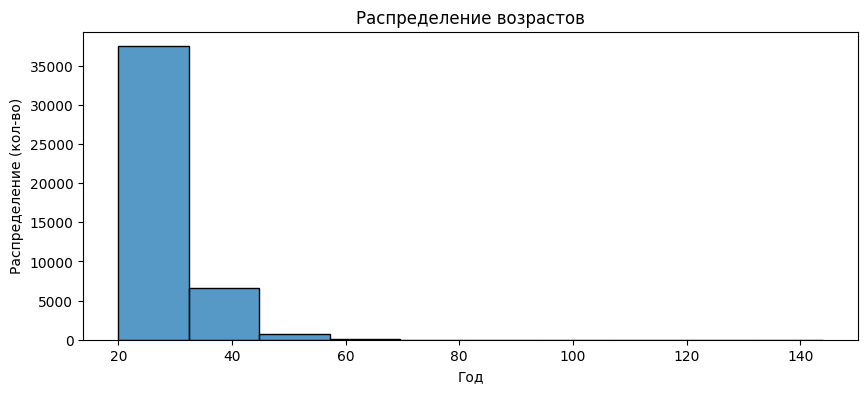

In [14]:
plt.figure(figsize=(10,4))
    
sns.histplot(df["person_age"], bins=10)

plt.title("Распределение возрастов")
plt.xlabel("Год")
plt.ylabel("Распределение (кол-во)")    

• Установим порог до 80 лет.

In [15]:
df = df.filter(pl.col("person_age") <= 80)

In [16]:
df.shape

(44991, 14)

Text(0, 0.5, 'Распределение (кол-во)')

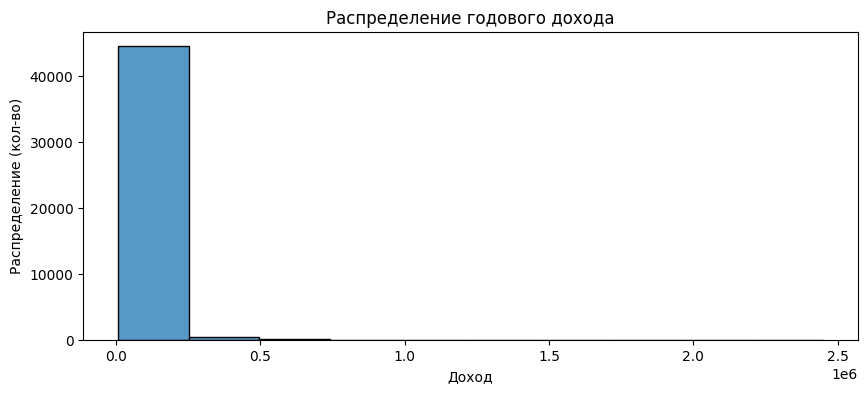

In [17]:
plt.figure(figsize=(10,4))
    
sns.histplot(df["person_income"], bins=10)

plt.title("Распределение годового дохода")
plt.xlabel("Доход")
plt.ylabel("Распределение (кол-во)") 

In [18]:
# Установим порог годового дохода до 0.5*1e6.
# df = df.filter(pl.col("person_income") <= 0.5*1e6)

In [19]:
#Income filter (using IQR)
income_Q1 = df['person_income'].quantile(0.25)
income_Q3 = df['person_income'].quantile(0.75)
income_IQR = income_Q3 - income_Q1
income_lower_bound = income_Q1 - 1.5 * income_IQR
income_upper_bound = income_Q3 + 1.5 * income_IQR
df = df.filter(
    (pl.col('person_income') >= income_lower_bound) &
    (pl.col('person_income') <= income_upper_bound)
)

Text(0, 0.5, 'Распределение (кол-во)')

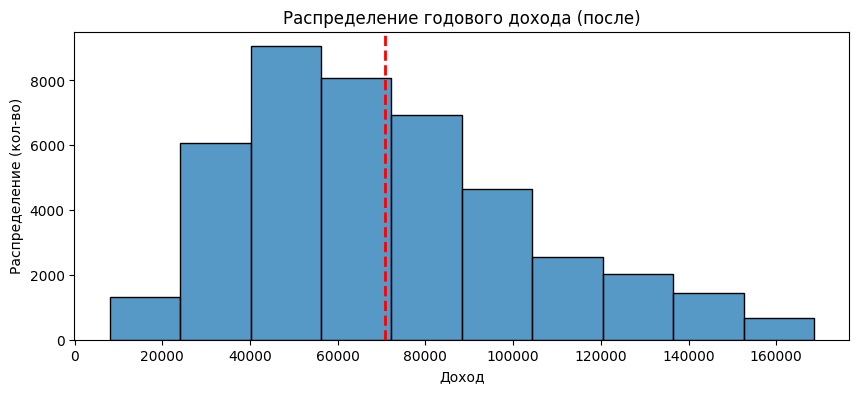

In [20]:
plt.figure(figsize=(10,4))

# Строим гистограмму   
sns.histplot(df["person_income"], bins=10)

# Вычисляем среднее
mean_value = df["person_income"].mean()

# Добавляем вертикальную линию
plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Среднее = {mean_value:.2f}')

plt.title("Распределение годового дохода (после)")
plt.xlabel("Доход")
plt.ylabel("Распределение (кол-во)") 

In [21]:
# IQR filter for other numeric variables
for col in features.numerical:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df.filter(
    (pl.col(col) >= lower_bound) &
    (pl.col(col) <= upper_bound)
    )

In [22]:
# Проверим, чтобы опыт работы был меньше чем возраст человека
df.filter(pl.col("person_emp_exp") >= pl.col("person_age"))

person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
f64,str,str,f64,i64,str,f64,str,f64,f64,f64,i64,str,i64


Text(0, 0.5, 'Частота')

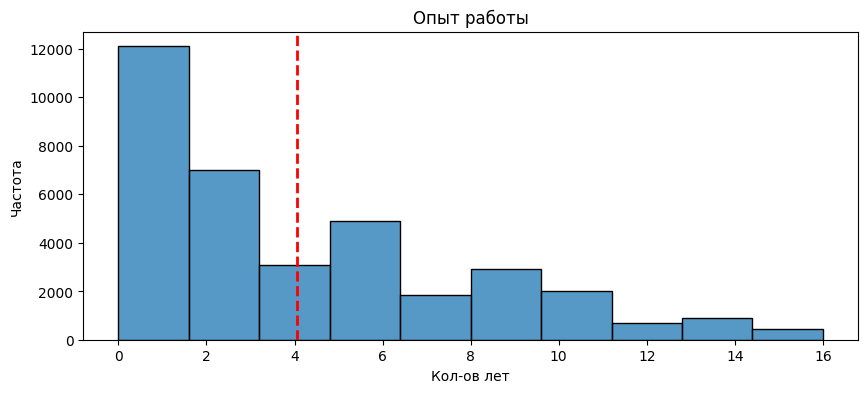

In [23]:
plt.figure(figsize=(10,4))

# Строим гистограмму   
sns.histplot(df["person_emp_exp"], bins=10)

# Вычисляем среднее
mean_value = df["person_emp_exp"].mean()

# Добавляем вертикальную линию
plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Среднее = {mean_value:.2f}')

plt.title("Опыт работы")
plt.xlabel("Кол-ов лет")
plt.ylabel("Частота") 

In [24]:
# Логарифмическое преобразование
# df = df.with_columns(pl.col("person_income").log1p())

### • Correlation matrix

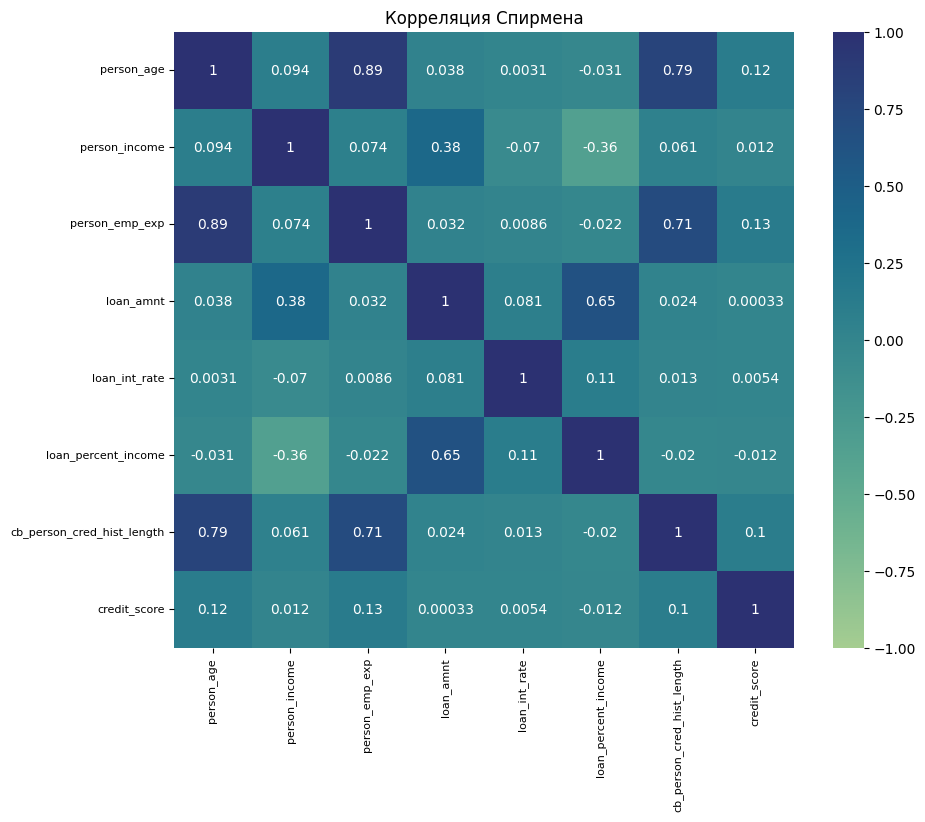

In [25]:
plt.figure(figsize=(10,8))

# Матрица корреляции
corr_matrix = df[features.numerical].corr()

# Конвертируем в numpy для визуализации
sns.heatmap(
    corr_matrix.to_numpy(),
    xticklabels=features.numerical,   # подписи по оси X (столбцы)
    yticklabels=features.numerical,   # подписи по оси Y (строки)
    annot=True,
    cmap='crest',
    vmin=-1,
    vmax=1
)

plt.title("Корреляция Спирмена")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

Корреляция между возрастом и годами опыта работы на уровне 0,95 указывает на очень сильную линейную зависимость между этими переменными. Это означает, что с увеличением возраста, как правило, растёт и стаж работы, и наоборот. Такая ситуация ожидаема, так как эти показатели напрямую связаны: чем старше человек, тем больше времени он потенциально мог посвятить профессиональной деятельности. Однако в контексте анализа данных такая высокая корреляция может создавать проблемы.

In [26]:
# Создадим новую переменную emp_exp_per_age = person_emp_exp / person_age
df = df.with_columns(
    ((pl.col("person_emp_exp")/pl.col("person_age"))*100)
    .alias("emp_exp_per_age")
)

In [27]:
# Исключим из списка "person_age" и "person_emp_exp" и добавим "emp_exp_per_age"
features.add("emp_exp_per_age", type_feature = "num")
features.remove(["person_age", "person_emp_exp"])

---

In [28]:
# Создадим новую переменную cred_hist_per_age = cb_person_cred_hist_length / person_age
df = df.with_columns(
    ((pl.col("cb_person_cred_hist_length")/pl.col("person_age"))*100)
    .alias("cred_hist_per_age")
)
features.add("cred_hist_per_age", type_feature = "num")
features.remove("cb_person_cred_hist_length")

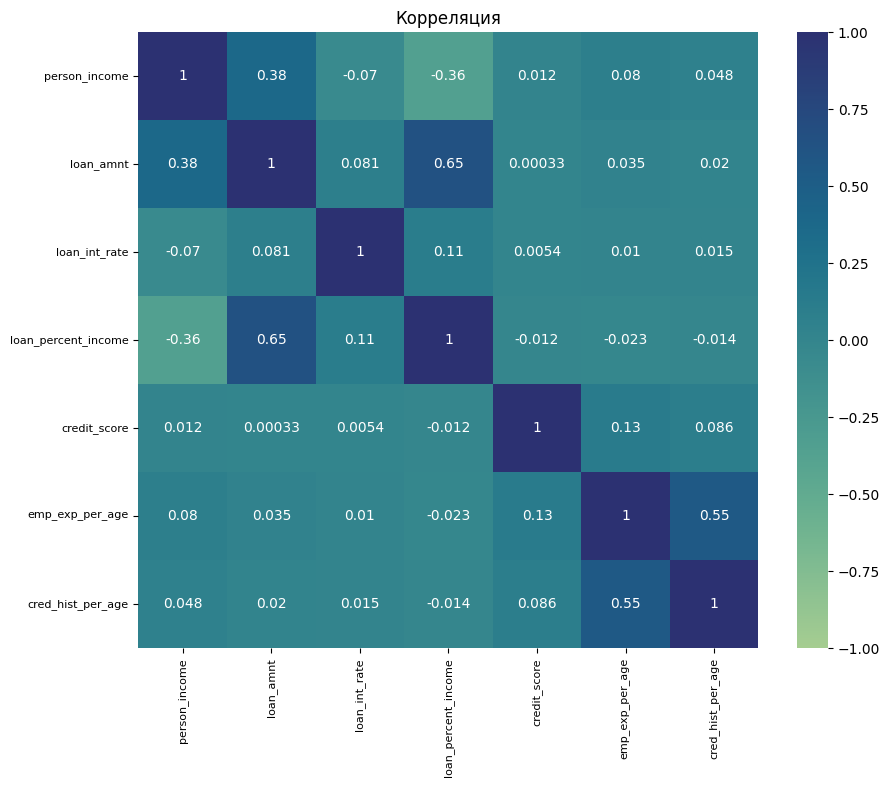

In [29]:
plt.figure(figsize=(10,8))

# Матрица корреляции
corr_matrix = df[features.numerical].corr()

# Конвертируем в numpy для визуализации
sns.heatmap(
    corr_matrix.to_numpy(),
    xticklabels=features.numerical,   # подписи по оси X (столбцы)
    yticklabels=features.numerical,   # подписи по оси Y (строки)
    annot=True,
    cmap='crest',
    vmin=-1,
    vmax=1
)

plt.title("Корреляция")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

### •  Analyzing the dependence of the target on features

Text(0, 0.5, 'Распределение (кол-во)')

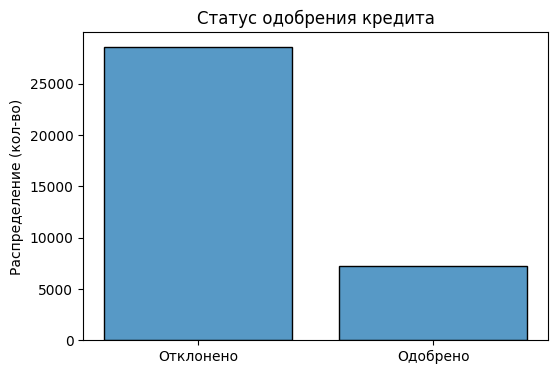

In [30]:
desk_loan_status = df.with_columns(pl.col(features.Y).replace_strict({0: "Отклонено", 1: "Одобрено"}).alias("desk_" + features.Y))

plt.figure(figsize=(6 ,4))

# Строим гистограмму   
sns.histplot(desk_loan_status, x="desk_loan_status", discrete=True, shrink=0.8)

plt.title("Статус одобрения кредита")
plt.xlabel("")
plt.ylabel("Распределение (кол-во)") 

Зависимость целевой переменной от всех числовых признаков

In [31]:
num = features.numerical
num.append(features.Y)

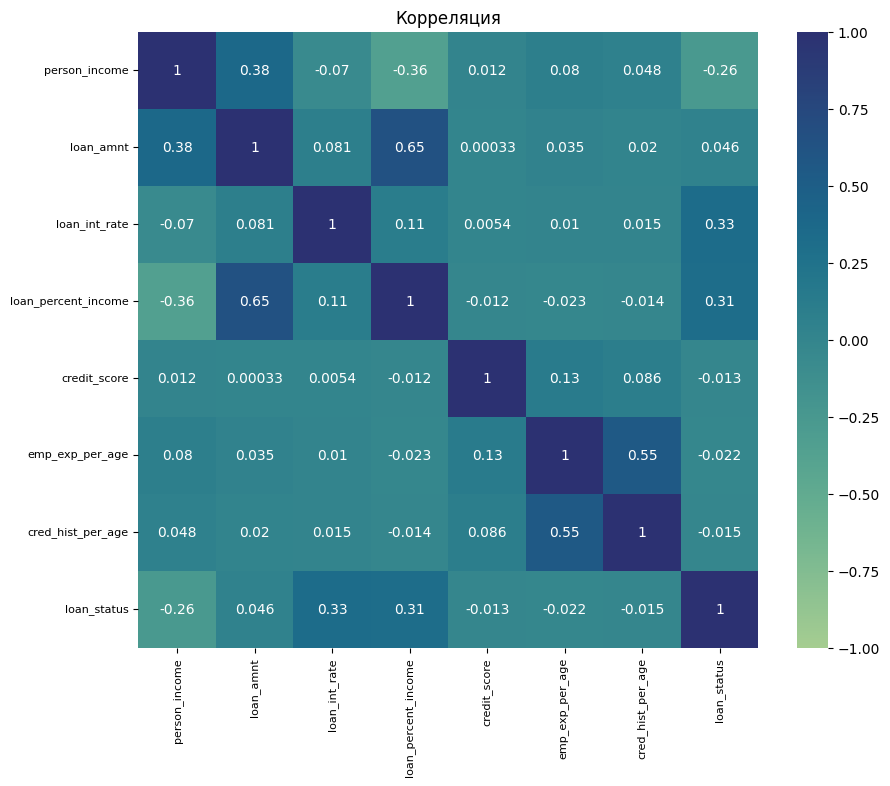

In [32]:
plt.figure(figsize=(10,8))

# Матрица корреляции
corr_matrix = df[num].corr()

# Конвертируем в numpy для визуализации
sns.heatmap(
    corr_matrix.to_numpy(),
    xticklabels=num,   # подписи по оси X (столбцы)
    yticklabels=num,   # подписи по оси Y (строки)
    annot=True,
    cmap='crest',
    vmin=-1,
    vmax=1
)

plt.title("Корреляция")
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.show()

## Split data

### • Split into training and test

In [33]:
# Отделяем test
X_temp, X_test, y_temp, y_test, = train_test_split(
    df[features.X], df[features.Y],
    test_size=TEST_SIZE,
    random_state=42
)

### •  Split into training and validation

In [34]:
# Второе разбиение: из остатка выделяем val (25% от 80% = 20% от исходных)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size = VAL_SIZE / (1 - TEST_SIZE),
    random_state=42
)

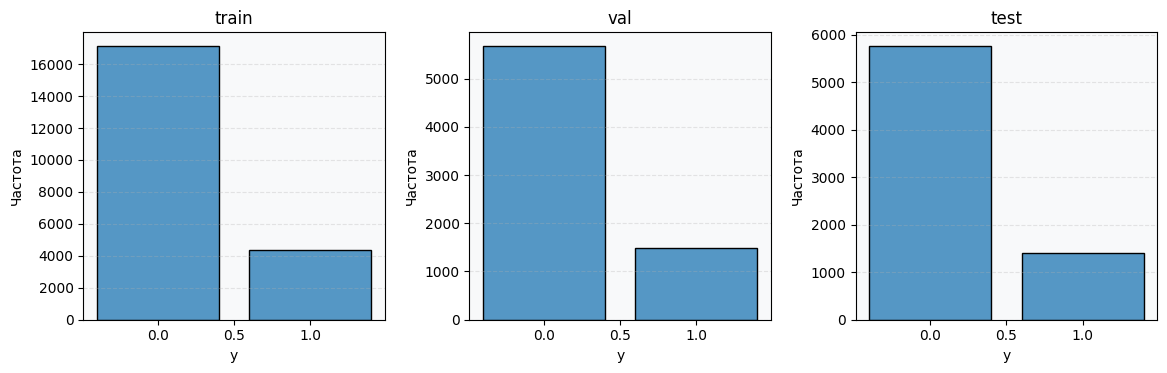

In [35]:
# Собираем данные для визуализации
plot_data = pl.DataFrame({
    "y": np.concatenate([y_train, y_val, y_test]),
    "set": ["train"] * len(y_train) + ["val"] * len(y_val) + ["test"] * len(y_test)
})

# Гистограммы
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
plt.tight_layout(pad=3.0)

for i, set_name in enumerate(["train", "val", "test"]):
    data = plot_data.filter(pl.col("set") == set_name)["y"]
    sns.histplot(data, discrete=True, shrink=0.8, ax=ax[i])
    ax[i].set_title(set_name)
    ax[i].set_xlabel("y")
    ax[i].set_ylabel("Частота")
    ax[i].grid(axis="y", alpha=0.3, linestyle='--')
    ax[i].set(facecolor='#f8f9fa')

plt.show()

## Permutation-based feature importance

In [37]:
# Создаем трансформер для обработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), features.categorical_idx(X_train))  # Кодирование категориальных признаков
    ]
)

# Создаем полный пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver="saga", random_state=42))
])

rf =  pipeline.fit(X_train.to_numpy(), y_train.to_numpy());

In [38]:
# Перемешиваем значения одного признака в тестовых данных и смотрим, насколько упала метрика модели.
result = permutation_importance(rf, X_train.to_numpy(), y_train.to_numpy(), n_repeats=5, random_state=42, n_jobs=12)

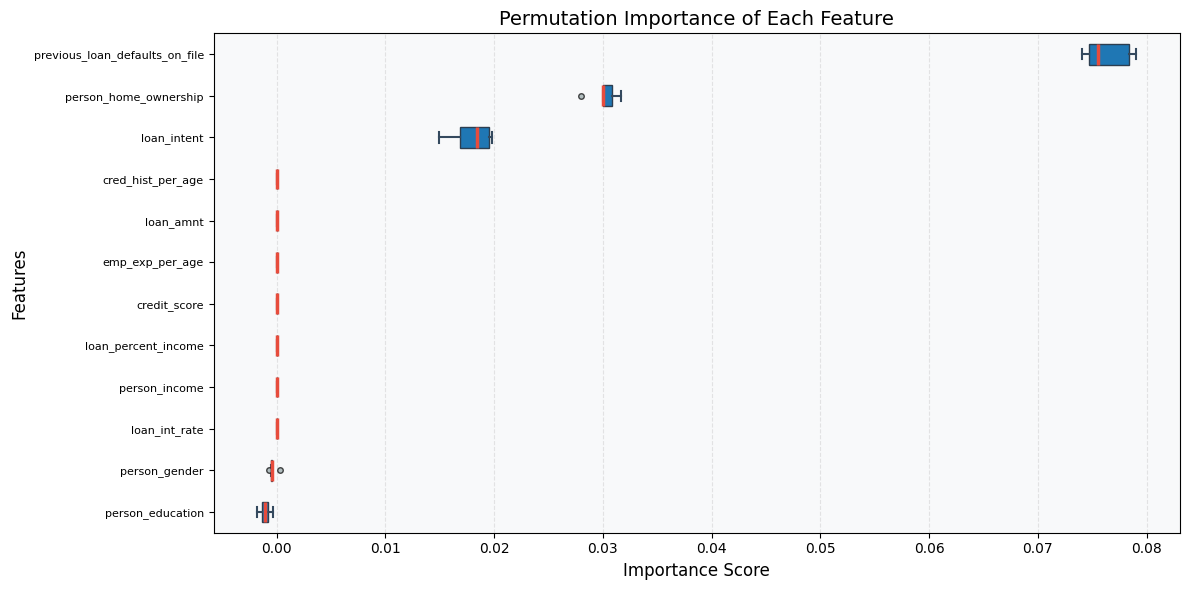

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))

sorted_idx = result.importances_mean.argsort()
feature_names = np.array(features.X)

# Создаем boxplot
boxprops = dict(linestyle='-', linewidth=1.0, color='#2c3e50')
whiskerprops = dict(linestyle='-', linewidth=1.5, color='#34495e')
capprops = dict(linewidth=1.5, color='#34495e')
medianprops = dict(linestyle='-', linewidth=2.5, color='#e74c3c')
flierprops = dict(marker='o', markerfacecolor='#95a5a6', markersize=4, alpha=0.7)

ax.boxplot(result.importances[sorted_idx].T, 
           vert=False, 
           tick_labels=feature_names[sorted_idx],
           boxprops=boxprops,
           whiskerprops=whiskerprops,
           capprops=capprops,
           medianprops=medianprops,
           flierprops=flierprops,
           patch_artist=True)  # Включаем заливку

# Добавляем цветовую заливку
colors = ['#3498db' for _ in range(len(sorted_idx))]
for patch, color in zip(ax.artists, colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Настройка заголовка и осей
ax.set_title("Permutation Importance of Each Feature", 
             fontsize=14)
ax.set_xlabel("Importance Score", fontsize=12)
ax.set_ylabel("Features", fontsize=12)

# Улучшаем сетку
ax.grid(axis='x', alpha=0.3, linestyle='--')
ax.set_axisbelow(True)

# Устанавливаем лимиты и улучшаем внешний вид
# ax.set_xlim(0, 0.1)
ax.set_facecolor('#f8f9fa')

# Увеличиваем шрифт меток признаков
ax.tick_params(axis='y', labelsize=8)

fig.tight_layout()
plt.show()

## Base model

In [37]:
# Создаем трансформер для обработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features.numerical_idx(X_train)),  # Нормализация числовых признаков
        ('cat', OneHotEncoder(), features.categorical_idx(X_train))  # Кодирование категориальных признаков
    ]
)

# Создаем полный пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', SGDClassifier(loss='log_loss', random_state=42))
])
SGDC = pipeline.fit(X_train.to_numpy(), y_train.to_numpy());

In [40]:
def _score(model):
    y_pred = model.predict(X_val.to_numpy())
    
    # Performance metrics
    roc_auc = round(roc_auc_score(y_val, model.predict_proba(X_val.to_numpy())[:, 1]), 4)
    f1 = round(f1_score(y_val, y_pred), 4)
    recall = round(recall_score(y_val, y_pred), 4)
    precision = round(precision_score(y_val, y_pred), 4)
    
    print(f"F1: {f1} \nprecision: {precision} \nrecall:{recall} \nROC AUC: {roc_auc} ")

In [46]:
_score(SGDC)

F1: 0.7602 
precision: 0.7259 
recall:0.798 
ROC AUC: 0.9559 


In [179]:
# Оцениваем модель на тестовых данных
y_pred = SGDC.predict(X_test.to_numpy())
# Performance metrics
roc_auc = round(roc_auc_score(y_test, SGDC.predict_proba(X_test.to_numpy())[:, 1]), 4)
f1 = round(f1_score(y_test, y_pred), 4)
recall = round(recall_score(y_test, y_pred), 4)
precision = round(precision_score(y_test, y_pred), 4)

print(f"F1: {f1} \nprecision: {precision} \nrecall:{recall} \nROC AUC: {roc_auc} ")

F1: 0.7413 
precision: 0.6975 
recall:0.791 
ROC AUC: 0.9499 


### • Selection of hyperparameters

In [53]:
# Пространство гиперпараметров
param_distributions = {
    'clf__loss': ['log_loss', 'modified_huber'],
    'clf__alpha': loguniform(1e-6, 1e-1),  # логарифмический диапазон
    'clf__penalty': ['l2', 'l1', 'elasticnet'],
    'clf__l1_ratio': uniform(0, 1),            # только если penalty='elasticnet'
    'clf__learning_rate': ['constant', 'optimal', 'invscaling', 'adaptive'],
    'clf__eta0': loguniform(1e-4, 1e0),     # начальный шаг
    'clf__max_iter': [500, 1000, 300],
    'clf__tol': [1e-4, 1e-3, 1e-2],
    'clf__average': [True, False],
    'clf__random_state': [42]
}

grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    cv=5,
    n_iter=50,
    scoring=['roc_auc', 'f1', 'precision', 'recall'],
    refit='roc_auc',
    error_score='raise', 
    n_jobs=12
).fit(X_train.to_numpy(), y_train.to_numpy());

In [54]:
grid_search.best_params_

{'clf__alpha': np.float64(4.207252460296817e-06),
 'clf__average': True,
 'clf__eta0': np.float64(0.034517307441539254),
 'clf__l1_ratio': np.float64(0.5528714764131636),
 'clf__learning_rate': 'constant',
 'clf__loss': 'log_loss',
 'clf__max_iter': 1000,
 'clf__penalty': 'l2',
 'clf__random_state': 42,
 'clf__tol': 0.01}

In [55]:
_score(grid_search.best_estimator_)

F1: 0.7518 
precision: 0.7717 
recall:0.7329 
ROC AUC: 0.9562 


### • Save model

In [56]:
# --- сохранение модели ---
model_path = os.path.join(".\models", "SGDClassifier.pkl")
joblib.dump(grid_search.best_estimator_, model_path)

['.\\models\\SGDClassifier.pkl']

### •  Confusion matrix

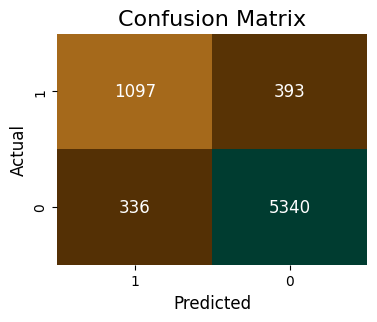

In [57]:
cm = confusion_matrix(y_val, clf.predict(X_val.to_numpy()), labels=[0, 1])

TN, FP, FN, TP = cm.ravel()

fp_fn_data = pl.DataFrame({
    '1': [TP, FP],
    '0': [FN, TN]
})

# Построение хитмапы
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(fp_fn_data, annot=True, cmap="BrBG", fmt='d', cbar=False,
            annot_kws={"size": 12})

ax.set_xticklabels(['1', '0'])
ax.set_yticklabels(['1', '0'])

plt.title('Confusion Matrix', fontsize=16)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

In [58]:
print(f'TP (True Positive): {TP} \
Это количество положительных случаев, которые правильно классифицированы моделью как положительные. \
\nТо есть {TP} клиентам одобрили кредит, и модель правильно предсказала это.')

print(f'\nFN (False Negative): {FN} \
Это количество положительных случаев, которые были ошибочно классифицированы как отрицательные. \
\nТо есть {FN} клиентам, которым одобрили кредит, модель посчитала, что нужно отказать этим клиентам.')

print(f'\nFP (False Positive): {FP} \
Это количество отрицательных случаев, которые были ошибочно классифицированы как положительные. \
\nТо есть {FP} клиентам, которым отказали, модель решила одобрить кредит.')

print(f'\nTN (True Negative): {TN} \
Это количество отрицательных случаев, которые правильно классифицированы моделью как отрицательные. \
\nТо есть {TN} клиентам отказали в кредите, модель правильно предсказала это.')

TP (True Positive): 1097 Это количество положительных случаев, которые правильно классифицированы моделью как положительные. 
То есть 1097 клиентам одобрили кредит, и модель правильно предсказала это.

FN (False Negative): 393 Это количество положительных случаев, которые были ошибочно классифицированы как отрицательные. 
То есть 393 клиентам, которым одобрили кредит, модель посчитала, что нужно отказать этим клиентам.

FP (False Positive): 336 Это количество отрицательных случаев, которые были ошибочно классифицированы как положительные. 
То есть 336 клиентам, которым отказали, модель решила одобрить кредит.

TN (True Negative): 5340 Это количество отрицательных случаев, которые правильно классифицированы моделью как отрицательные. 
То есть 5340 клиентам отказали в кредите, модель правильно предсказала это.


## KNN model

In [63]:
# Создаем пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', KNeighborsClassifier())
])

param_distributions = {
    'clf__n_neighbors': [3, 5, 7, 10, 20, 40, 45],
    'clf__weights': ['uniform', 'distance'],  # Взвешенные соседи или нет
    'clf__metric': ['manhattan', 'euclidean']
}

grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    cv=5,
    n_iter=50,
    scoring=['roc_auc', 'f1', 'precision', 'recall'],
    refit='f1',
    error_score='raise', 
    n_jobs=12
).fit(X_train.to_numpy(), y_train.to_numpy());

_score(grid_search.best_estimator_)

F1: 0.738 
precision: 0.8033 
recall:0.6826 
ROC AUC: 0.9478 


In [66]:
grid_search.best_params_

{'clf__weights': 'distance',
 'clf__n_neighbors': 10,
 'clf__metric': 'manhattan'}

## SVM model

In [49]:
# Создаем пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', SVC(kernel='linear', gamma='scale'))
])

param_distributions = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__kernel': ['linear'],
    'clf__gamma': ['scale', 0.01, 0.1, 1]
}

grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    cv=5,
    n_iter=50,
    scoring=['roc_auc', 'f1', 'precision', 'recall'],
    refit='f1',
    error_score='raise', 
    n_jobs=6
).fit(X_train.to_numpy(), y_train.to_numpy());

In [50]:
y_pred = grid_search.best_estimator_.predict(X_val.to_numpy())

# Performance metrics
f1 = round(f1_score(y_val, y_pred), 4)
recall = round(recall_score(y_val, y_pred), 4)
precision = round(precision_score(y_val, y_pred), 4)

print(f"F1: {f1} \nprecision: {precision} \nrecall:{recall}")

F1: 0.6347 
precision: 0.5788 
recall:0.7027


In [ ]:
grid_search.best_params_

## Random Forest model

In [42]:
# Создаем трансформер для обработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), features.categorical_idx(X_train))  # Кодирование категориальных признаков
    ]
)

# Создаем полный пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

param_distributions = {
    "clf__min_samples_split": [2, 5, 10, 20, 50, 100],  # range(2, 200),
    "clf__min_samples_leaf": [1, 2, 5, 10, 20, 50]  # range(1, 200),
}

grid_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    cv=5,
    n_iter=50,
    scoring=['roc_auc', 'f1', 'precision', 'recall'],
    refit='f1',
    error_score='raise', 
    n_jobs=6
).fit(X_train.to_numpy(), y_train.to_numpy());

In [43]:
_score(grid_search.best_estimator_)

F1: 0.5753 
precision: 0.6019 
recall:0.551 
ROC AUC: 0.8961 


## CatBoost model

In [53]:
catboost = CatBoostClassifier(
    cat_features=features.categorical_idx(X_train),
    iterations=500,
    learning_rate=0.05,
    depth=4,
    early_stopping_rounds=20,
    eval_metric='F1',
    random_seed=42,
    verbose=100
)

catboost.fit(
    X_train.to_numpy(),
    y_train.to_numpy(),
    eval_set = (X_val.to_numpy(), y_val.to_numpy()),
    use_best_model = True
)

0:	learn: 0.6830553	test: 0.6973294	best: 0.6973294 (0)	total: 189ms	remaining: 1m 34s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.7489177489
bestIteration = 4

Shrink model to first 5 iterations.


In [54]:
_score(catboost)

F1: 0.7489 
precision: 0.8097 
recall:0.6966 
ROC AUC: 0.9484 


### • Selection of hyperparameters

In [94]:
# Подбор гиперпараметров для модели CatBoostClassifier
# В CatBoostClassifier параметры n_estimators, num_trees, iterations и num_boost_round полностью эквивалентны
def objective(trial):

    params = {
        "iterations": trial.suggest_int("iterations", 300, 800),  # Количество итераций (деревьев)          
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),  # Скорость обучения
        "depth": trial.suggest_int("depth", 3, 6),  # Глубина деревьев
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),  # L2-регуляризация
        "border_count": trial.suggest_categorical("border_count", [32, 64, 128, 254]),  # Количество границ для числовых признаков
        "random_strength": trial.suggest_int("random_strength", 1, 20),  # Сила случайности при выборе разделений
        # "rsm": trial.suggest_float("rsm", 0.5, 1.0),  # Доля признаков для рассмотрения в каждом разделении (не работает с GPU)
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),  # Стратегия роста деревьев
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian"]),  # Метод бустраппинга
        "loss_function": trial.suggest_categorical("loss_function", ["Logloss"]),  # Функция потерь
        "eval_metric": "F1",  # Метрика оценки
        "verbose": False,  # Вывод информации о обучении
        "random_seed": 42,  # Случайное зерно для воспроизводимости
        "thread_count": 10,  # Количество ядер для CatBoost
        "early_stopping_rounds": 20,  # Количество раундов для ранней остановки
        "auto_class_weights": "Balanced",  # Автоматические веса классов для несбалансированных данных
        "task_type": 'GPU',
    }
    
    # Указываем категориальные признаки
    params["cat_features"] = features.categorical_idx(X_train)
    
    # --- пайплайн ---
    model = CatBoostClassifier(**params)

    # --- кросс-валидация ---
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    f1, aucs, precisions, recalls = [], [], [], []
    for train_idx, valid_idx in cv.split(X_train, y_train):
        X_tr, X_val = X_train.to_numpy()[train_idx], X_train.to_numpy()[valid_idx]
        y_tr, y_val = y_train.to_numpy()[train_idx], y_train.to_numpy()[valid_idx]

        # Обучение модели
        model.fit(X_tr, y_tr)

        # Предсказание модели
        y_pred = model.predict(X_val)
        # Предсказанные вероятности для первого класса
        y_proba = model.predict_proba(X_val)[:, 1]

        f1.append(f1_score(y_val, y_pred))
        aucs.append(roc_auc_score(y_val, y_proba))
        precisions.append(precision_score(y_val, y_pred))
        recalls.append(recall_score(y_val, y_pred))

    metrics = {
        "f1": np.mean(f1),
        "precision": np.mean(precisions),
        "recall": np.mean(recalls),
        "roc_auc": np.mean(aucs),
    }

    # сохраняем гиперпараметры
    config_path = os.path.join("./configs/CatBoost", f"params_and_metrics_{trial.number}.json")
    with open(config_path, "w") as f:
        json.dump({"params": params, "metrics": metrics}, f, indent=4)

    return metrics["f1"]

In [97]:
# --- запуск эксперимента ---
study = optuna.create_study(
    direction="maximize",
    study_name="my_study",
    storage="sqlite:///optuna/my_study.db",  # обязательно для параллелизма
    load_if_exists=True,
    sampler=optuna.samplers.TPESampler(seed=42))

study.optimize(objective, n_trials=50);

[I 2026-02-05 16:10:10,793] Using an existing study with name 'my_study' instead of creating a new one.
[I 2026-02-05 16:11:15,271] Trial 17 finished with value: 0.8019237232139158 and parameters: {'iterations': 487, 'learning_rate': 0.22648248189516848, 'depth': 5, 'l2_leaf_reg': 6, 'border_count': 254, 'random_strength': 13, 'grow_policy': 'Lossguide', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 17 with value: 0.8019237232139158.
[I 2026-02-05 16:12:31,638] Trial 18 finished with value: 0.7114858073506551 and parameters: {'iterations': 717, 'learning_rate': 0.0033572967053517922, 'depth': 3, 'l2_leaf_reg': 2, 'border_count': 64, 'random_strength': 13, 'grow_policy': 'Lossguide', 'bootstrap_type': 'Bayesian', 'loss_function': 'Logloss'}. Best is trial 17 with value: 0.8019237232139158.
[I 2026-02-05 16:13:26,184] Trial 19 finished with value: 0.7676535699871054 and parameters: {'iterations': 528, 'learning_rate': 0.08810003129071789, 'depth': 3, 'l2_leaf_r

### • Selecting metric values

In [108]:
_path = Path("./configs/CatBoost")
all_data = []

for json_file in _path.glob("*.json"):
    with json_file.open("r", encoding="utf-8") as f:
        data = json.load(f)
        data["name_file"] = json_file.name
        all_data.append(data)

In [113]:
CatMetrics = pl.DataFrame([
    {
        "f1": data["metrics"]["f1"],
        "precision": data["metrics"]["precision"],
        "recall": data["metrics"]["recall"],
        "roc_auc": data["metrics"]["roc_auc"],
        "file_name": data["name_file"]
    }
    for data in all_data
])

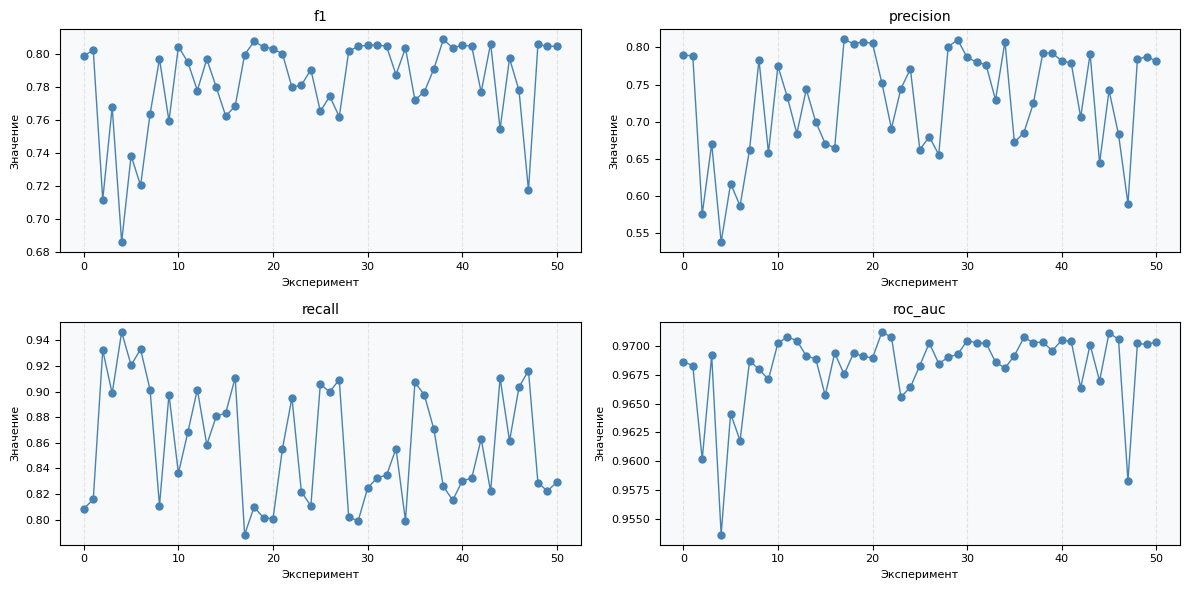

In [166]:
n_cols = 2
n_rows = 2
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 3 * n_rows))

name_col = ["f1", "precision", "recall", "roc_auc"]

for i, col in enumerate(name_col, 1):
    ax = axes[(i-1) // n_cols, (i-1) % n_cols]
    ax.plot(CatMetrics[col], marker='o', markersize=5, linestyle='-', linewidth=1, color='steelblue')
    
    ax.set_title(name_col[i-1], fontsize=10)
    ax.set_xlabel("Эксперимент", fontsize=8)
    ax.set_ylabel("Значение", fontsize=8)
    
    ax.tick_params(axis='both', labelsize=8)
    
    ax.set_facecolor('#f8f9fa')
    ax.grid(axis='x', alpha=0.3, linestyle='--')
    
fig.tight_layout()
plt.show()

In [187]:
# Среди всех метрик выберим наибольшее значение f1 при условии, что recall и precision, будут примерно одинаковыми.
CatMetrics.sort(pl.col("f1"), descending=True).head(10)

f1,precision,recall,roc_auc,file_name
f64,f64,f64,f64,str
0.808541,0.79231,0.825999,0.970354,"""params_and_metrics_54.json"""
0.807387,0.805131,0.809973,0.969404,"""params_and_metrics_34.json"""
0.806065,0.791176,0.822108,0.970126,"""params_and_metrics_59.json"""
0.805558,0.78396,0.828975,0.970235,"""params_and_metrics_64.json"""
0.805372,0.780087,0.832868,0.970286,"""params_and_metrics_47.json"""
0.805029,0.78161,0.83035,0.970521,"""params_and_metrics_56.json"""
0.804935,0.786571,0.824627,0.97048,"""params_and_metrics_46.json"""
0.80448,0.78136,0.829433,0.97037,"""params_and_metrics_66.json"""
0.80447,0.810165,0.799215,0.96929,"""params_and_metrics_45.json"""


### • Select the best model

In [191]:
# --- обучение финальной модели ---
path = Path("./configs/CatBoost/params_and_metrics_54.json") 
with path.open("r", encoding="utf-8") as f:
    data = json.load(f)
    
    best_params = data["params"]
    # best_params["cat_features"] = features.categorical_idx(X_train)
    
CatBoost = CatBoostClassifier(**best_params)

CatBoost.fit(
    X_train.to_numpy(),
    y_train.to_numpy(),
    eval_set = (X_val.to_numpy(), y_val.to_numpy()),
    use_best_model = True,
    verbose = False
)

In [192]:
# Оцениваем модель на валидационных данных 
_score(CatBoost)

F1: 0.7973 
precision: 0.7011 
recall:0.9242 
ROC AUC: 0.9757 


In [193]:
# Оцениваем модель на тестовых данных
y_pred = CatBoost.predict(X_test.to_numpy())
# Performance metrics
roc_auc = round(roc_auc_score(y_test, CatBoost.predict_proba(X_test.to_numpy())[:, 1]), 4)
f1 = round(f1_score(y_test, y_pred), 4)
recall = round(recall_score(y_test, y_pred), 4)
precision = round(precision_score(y_test, y_pred), 4)

print(f"F1: {f1} \nprecision: {precision} \nrecall:{recall} \nROC AUC: {roc_auc} ")

F1: 0.7795 
precision: 0.6801 
recall:0.913 
ROC AUC: 0.9734 


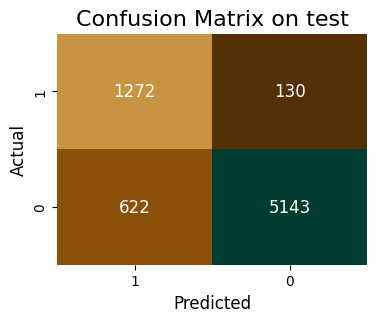

In [178]:
cm = confusion_matrix(y_test, CatBoost.predict(X_test.to_numpy()), labels=[0, 1])

TN, FP, FN, TP = cm.ravel()

fp_fn_data = pl.DataFrame({
    '1': [TP, FP],
    '0': [FN, TN]
})

# Построение хитмапы
fig, ax = plt.subplots(figsize=(4, 3))
sns.heatmap(fp_fn_data, annot=True, cmap="BrBG", fmt='d', cbar=False,
            annot_kws={"size": 12})

ax.set_xticklabels(['1', '0'])
ax.set_yticklabels(['1', '0'])

plt.title('Confusion Matrix on test', fontsize=16)
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

### • Save model

In [104]:
# --- сохранение модели ---
model_path = os.path.join(MODELS_DIR, "catboost_best.pkl")
joblib.dump(best_model, model_path)

['models\\catboost_best.pkl']

### • Loading model

In [ ]:
# # --- загрузить обученную модель ---
# model_path = os.path.join(MODELS_DIR, "catboost_best.pkl")
# catboost = joblib.load(model_path)

## Summary

Модель логистической регрессии (из коробки) показала высокий результа. Подбор гиперпараметров не дал результата лучше.  
- F1: 0.7413  
- precision: 0.6975  
- recall: 0.791  
- ROC AUC: 0.9499  

При обучении CatBoost модель смогла превзойти результат логистической регрессии.  
- F1: 0.7795 
- precision: 0.6801  
- recall: 0.913
- ROC AUC: 0.9734 

Основной выбор был модели по ROC AUC и F1 метрикам, т.к. учитывалась важность обоих классов.  
Модель с высоким precision может одобрить мало клиентов, но почти все они будут «правильными».
Низкий recall означает, что модель пропускает много клиентов, которым можно было одобрить кредит.